In [1]:
import numpy as np
import pandas as pd
import time
import warnings
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from helpers import preprocess, evaluate, select_params

%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')

# Chapter IV - Fit Machine Learning Models
Perform feature engineering on the combined training & test dataset before fitting machine learning models.

In [2]:
train_df, test_df = preprocess("input/train.csv", "input/test.csv")
print("Dimension of training data: ", train_df.shape)
print("Dimension of test data: ", test_df.shape)
train_df.head()

{'A': 36.0, 'B': 102.0, 'C': 148.0, 'D': 56.0, 'E': 121.0, 'F': 73.0, 'G': 6.0, 'T': nan, 'U': nan}
One-hot encoded columns:  Index(['PassengerId', 'Survived', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Cabin', 'FamilySize', 'NormalizedFamilySize', 'IsAlone',
       'NameLength', 'NormalizedNameLength', 'HasCabin', 'Deck', 'Room',
       'NormalizedRoomNo', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'CategoricalAge_0', 'CategoricalAge_1', 'CategoricalAge_2',
       'CategoricalAge_3', 'CategoricalAge_4', 'Fare_0', 'Fare_1', 'Fare_2',
       'Fare_3', 'Embarked_0', 'Embarked_1', 'Embarked_2', 'Title_1',
       'Title_2', 'Title_3', 'Title_4', 'Title_5'],
      dtype='object')
{'A': 34.0, 'B': 78.0, 'C': 132.0, 'D': 43.0, 'E': 60.0, 'F': 63.0, 'G': 6.0, 'U': nan}
One-hot encoded columns:  Index(['PassengerId', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Cabin', 'FamilySize', 'NormalizedFamilySize', 'IsAlone', 'NameLength',
       'NormalizedNameLength', 'HasC

,Survived,Name,Sex,Age,NormalizedFamilySize,IsAlone,NormalizedNameLength,HasCabin,NormalizedRoomNo,Pclass_1,...,Fare_2,Fare_3,Embarked_0,Embarked_1,Embarked_2,Title_1,Title_2,Title_3,Title_4,Title_5
0,0,"Braund, Mr. Owen Harris",1,22.0,0.1,0,0.157143,0,0.504337,0,...,0,0,1,0,0,1,0,0,0,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,0.1,0,0.557143,1,0.574324,1,...,0,1,0,1,0,0,0,1,0,0
2,1,"Heikkinen, Miss. Laina",0,26.0,0.0,1,0.142857,0,0.504337,0,...,0,0,1,0,0,0,1,0,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,0.1,0,0.457143,1,0.831081,1,...,0,1,1,0,0,0,0,1,0,0
4,0,"Allen, Mr. William Henry",1,35.0,0.0,1,0.171429,0,0.504337,0,...,0,0,1,0,0,1,0,0,0,0


Normalize the passengers' name by removing the quotation mark

In [3]:
test_df["cleaned_name"] = test_df["Name"].apply(lambda name: name.replace('\"', ''))
ground_truth_df = pd.read_csv("input/ground-truth.csv")
ground_truth_df["cleaned_name"] = ground_truth_df["name"].apply(lambda name: name.replace('\"', ''))
test_df = pd.merge(test_df, ground_truth_df[["cleaned_name", "age", "survived"]], how="left",
                   left_on=["cleaned_name", "Age"], right_on=["cleaned_name", "age"])
test_df = test_df.rename(columns={"survived": "GroundTruth"})
test_df.head()

,Name,Sex,Age,NormalizedFamilySize,IsAlone,NormalizedNameLength,HasCabin,NormalizedRoomNo,Pclass_1,Pclass_2,...,Embarked_1,Embarked_2,Title_1,Title_2,Title_3,Title_4,Title_5,cleaned_name,age,GroundTruth
0,"Kelly, Mr. James",1,34.5,0.0,1,0.06,0,0.578825,0,0,...,0,1,1,0,0,0,0,"Kelly, Mr. James",34.5,0
1,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,0.1,0,0.38,0,0.578825,0,0,...,0,0,0,0,1,0,0,"Wilkes, Mrs. James (Ellen Needs)",47.0,1
2,"Myles, Mr. Thomas Francis",1,62.0,0.0,1,0.24,0,0.578825,0,1,...,0,1,1,0,0,0,0,"Myles, Mr. Thomas Francis",62.0,0
3,"Wirz, Mr. Albert",1,27.0,0.0,1,0.06,0,0.578825,0,0,...,0,0,1,0,0,0,0,"Wirz, Mr. Albert",27.0,0
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,0.2,0,0.62,0,0.578825,0,0,...,0,0,0,0,1,0,0,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1


Verify complete match between test data and ground truth

In [4]:
test_df[test_df["GroundTruth"].isnull()]

,Name,Sex,Age,NormalizedFamilySize,IsAlone,NormalizedNameLength,HasCabin,NormalizedRoomNo,Pclass_1,Pclass_2,...,Embarked_1,Embarked_2,Title_1,Title_2,Title_3,Title_4,Title_5,cleaned_name,age,GroundTruth


In [5]:
train_df = train_df.drop(["Name", "Age"], axis = 1)
test_df = test_df.drop(["Name", "Age", "cleaned_name", "age"], axis = 1)
print("Dimension of training data: ", train_df.shape)
print("Dimension of test data: ", test_df.shape)

features = list(train_df.columns)
features.remove('Survived')
print(features)

Dimension of training data:  (891, 27)
Dimension of test data:  (418, 27)
['Sex', 'NormalizedFamilySize', 'IsAlone', 'NormalizedNameLength', 'HasCabin', 'NormalizedRoomNo', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'CategoricalAge_0', 'CategoricalAge_1', 'CategoricalAge_2', 'CategoricalAge_3', 'CategoricalAge_4', 'Fare_0', 'Fare_1', 'Fare_2', 'Fare_3', 'Embarked_0', 'Embarked_1', 'Embarked_2', 'Title_1', 'Title_2', 'Title_3', 'Title_4', 'Title_5']


## 4.1 Logistic Regression

In [6]:
survival_logreg = LogisticRegression()
survival_logreg.fit(train_df[features], train_df['Survived'])
print(survival_logreg)
evaluate(survival_logreg, test_df[features], test_df['GroundTruth'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
[[206  54]
 [ 41 117]]
True positive:  117
True negative:  206
False positive:  54
False negative:  41
Accuracy = (tp + tn) / (p + n), Accuracy =  0.772727
Precision = tp / (tp + fp), Precision =  0.684211
Recall = tp / (tp + fn), Recall =  0.740506
ROC =  0.766407


In [7]:
# tuned_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# tuned_parameters = {'C': [0.5, 1, 3, 5]}
tuned_parameters = {'C': [2, 3, 4]}
logreg_grid, best_score = select_params(LogisticRegression(C=1.0, intercept_scaling=1, dual=False,
                                                           fit_intercept=True, penalty='l2', tol=0.0001),
                                        tuned_parameters, train_df[features], train_df['Survived'], 5)
print(best_score)
evaluate(logreg_grid.best_estimator_, test_df[features], test_df['GroundTruth'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 3}

Grid scores on development set:

0.829 (+/-0.043) for {'C': 2}
0.831 (+/-0.041) for {'C': 3}
0.829 (+/-0.043) for {'C': 4}
Elapsed time: 0.1733 seconds

{'accuracy': 0.8305274971941639}
[[206  54]
 [ 41 117]]
True positive:  117
True negative:  206
False positive:  54
False negative:  41
Accuracy = (tp + tn) / (p + n), Accuracy =  0.772727
Precision = tp / (tp + fp), Precision =  0.684211
Recall = tp / (tp + fn), Recall =  0.740506
ROC =  0.766407


## 4.2 Random Forest
Fit baseline model.

In [8]:
survival_rf = RandomForestClassifier()
survival_rf.fit(train_df[features], train_df['Survived'])
print(survival_rf)
evaluate(survival_rf, test_df[features], test_df['GroundTruth'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
[[204  56]
 [ 48 110]]
True positive:  110
True negative:  204
False positive:  56
False negative:  48
Accuracy = (tp + tn) / (p + n), Accuracy =  0.751196
Precision = tp / (tp + fp), Precision =  0.662651
Recall = tp / (tp + fn), Recall =  0.696203
ROC =  0.740409


In [9]:
# Examine the parameters used by our current forest
print('Parameters currently in use:\n')
pprint(survival_rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Perform grid search on model parameters

In [39]:
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Create the random grid
tuned_parameters = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
                    'max_features': ['auto', 'sqrt'],
                    'max_depth': max_depth,
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4],
                    'bootstrap': [True, False]}
rf_random = select_params(RandomForestClassifier(), tuned_parameters,
                          train_df[features], train_df['Survived'], 5, False)
evaluate(rf_random.best_estimator_, test_df[features], test_df['GroundTruth'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}

Grid scores on development set:

0.815 (+/-0.042) for {'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
0.828 (+/-0.046) for {'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}
0.823 (+/-0.056) for {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}
0.823 (+/-0.045) for {'n_estimators': 1400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 40, 'bootstrap': False}
0.815 (+/-0.042) for {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap

Plot feature importance

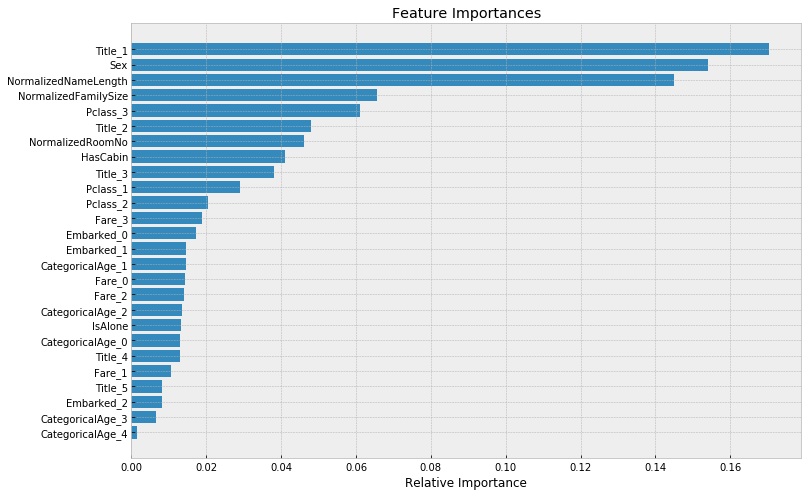

In [40]:
importances = rf_random.best_estimator_.feature_importances_
indices = np.argsort(importances)

fig = plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 4.3 Support Vector Machine

In [41]:
survival_svm = SVC(gamma='auto')
survival_svm.fit(train_df[features], train_df['Survived'])
print(survival_svm)
evaluate(survival_svm, test_df[features], test_df['GroundTruth'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[[215  45]
 [ 45 113]]
True positive:  113
True negative:  215
False positive:  45
False negative:  45
Accuracy = (tp + tn) / (p + n), Accuracy =  0.784689
Precision = tp / (tp + fp), Precision =  0.71519
Recall = tp / (tp + fn), Recall =  0.71519
ROC =  0.771056


In [48]:
# Set the parameters by cross-validation
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [5e-06, 1e-05, 3e-05],
#                      'C': [4500, 5000, 5500]}]
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.001, 0.01, 0.1, 1],
#                      'C': [0.001, 0.01, 0.1, 1, 10]},
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.01, 0.05, 0.1, 0.5, 1],
#                      'C': [0.1, 0.5, 1, 5, 10]},
#                     {'kernel': ['linear'], 'C': [10]}]
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.03, 0.05, 0.07],
#                      'C': [3, 5, 7]},
#                     {'kernel': ['linear'], 'C': [10]}]
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [0.02, 0.03, 0.04],
                     'C': [2, 3, 4]},
                    {'kernel': ['linear'], 'C': [10]}]
svm_grid = select_params(SVC(), tuned_parameters,
                         train_df[features], train_df['Survived'], 5)
evaluate(svm_grid.best_estimator_, test_df[features], test_df['GroundTruth'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 4, 'gamma': 0.03, 'kernel': 'rbf'}

Grid scores on development set:

0.795 (+/-0.049) for {'C': 2, 'gamma': 0.02, 'kernel': 'rbf'}
0.806 (+/-0.038) for {'C': 2, 'gamma': 0.03, 'kernel': 'rbf'}
0.829 (+/-0.042) for {'C': 2, 'gamma': 0.04, 'kernel': 'rbf'}
0.799 (+/-0.043) for {'C': 3, 'gamma': 0.02, 'kernel': 'rbf'}
0.828 (+/-0.039) for {'C': 3, 'gamma': 0.03, 'kernel': 'rbf'}
0.828 (+/-0.041) for {'C': 3, 'gamma': 0.04, 'kernel': 'rbf'}
0.815 (+/-0.040) for {'C': 4, 'gamma': 0.02, 'kernel': 'rbf'}
0.831 (+/-0.040) for {'C': 4, 'gamma': 0.03, 'kernel': 'rbf'}
0.820 (+/-0.042) for {'C': 4, 'gamma': 0.04, 'kernel': 'rbf'}
0.826 (+/-0.048) for {'C': 10, 'kernel': 'linear'}
Elapsed time: 1.7442 seconds

[[213  47]
 [ 46 112]]
True positive:  112
True negative:  213
False positive:  47
False negative:  46
Accuracy = (tp + tn) / (p + n), Accuracy =  0.777512
Precision = tp / (tp + fp), Precision =  0.

## 4.4 XGBoost
### 4.4.1 Build a baseline model with fix learning rate and number of estimators.

In [50]:
survival_xgb = XGBClassifier(learning_rate=0.1,
                             n_estimators=1000,
                             max_depth=5,
                             min_child_weight=1,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'binary:logistic',
                             nthread=4,
                             scale_pos_weight=1,
                             seed=27)
survival_xgb.fit(train_df[features], train_df['Survived'])
print(survival_xgb)
evaluate(survival_xgb, test_df[features], test_df['GroundTruth'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)
[[203  57]
 [ 49 109]]
True positive:  109
True negative:  203
False positive:  57
False negative:  49
Accuracy = (tp + tn) / (p + n), Accuracy =  0.746411
Precision = tp / (tp + fp), Precision =  0.656627
Recall = tp / (tp + fn), Recall =  0.689873
ROC =  0.735321


### General approach of tuning XGBoost parameters
<ol>
    <li>Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.</li>
    <li>Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.</li>
    <li>Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.</li>
    <li>Lower the learning rate and decide the optimal parameters.</li>
</ol>

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
### 4.4.2 Tune max_depth and min_child_weight

In [53]:
# tuned_parameters = {
#     "max_depth"        : range(3, 10, 2),
#     "min_child_weight" : range(1, 6, 2)
# }
tuned_parameters = {
    "max_depth"        : [4, 5, 6],
    "min_child_weight" : [1, 2, 3]
}
model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=140,
                          max_depth=5,
                          min_child_weight=1,
                          gamma=0,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          objective= 'binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          seed=27)
xgb_grid = select_params(model_xgb, tuned_parameters,
                         train_df[features], train_df['Survived'], 5)
evaluate(xgb_grid.best_estimator_, test_df[features], test_df['GroundTruth'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'max_depth': 5, 'min_child_weight': 1}

Grid scores on development set:

0.822 (+/-0.049) for {'max_depth': 4, 'min_child_weight': 1}
0.824 (+/-0.037) for {'max_depth': 4, 'min_child_weight': 2}
0.825 (+/-0.029) for {'max_depth': 4, 'min_child_weight': 3}
0.831 (+/-0.044) for {'max_depth': 5, 'min_child_weight': 1}
0.824 (+/-0.036) for {'max_depth': 5, 'min_child_weight': 2}
0.826 (+/-0.024) for {'max_depth': 5, 'min_child_weight': 3}
0.817 (+/-0.046) for {'max_depth': 6, 'min_child_weight': 1}
0.823 (+/-0.032) for {'max_depth': 6, 'min_child_weight': 2}
0.822 (+/-0.042) for {'max_depth': 6, 'min_child_weight': 3}
Elapsed time: 5.6782 seconds

[[203  57]
 [ 44 114]]
True positive:  114
True negative:  203
False positive:  57
False negative:  44
Accuracy = (tp + tn) / (p + n), Accuracy =  0.758373
Precision = tp / (tp + fp), Precision =  0.666667
Recall = tp / (tp + fn), Recall =  0.721519
ROC =  0.7

### 4.4.3 Tune gamma

In [55]:
tuned_parameters = {
    "gamma"        : [i/10.0 for i in range(0, 5)]
}
model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=140,
                          max_depth=5,
                          min_child_weight=1,
                          gamma=0,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          objective= 'binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          seed=27)
xgb_grid = select_params(model_xgb, tuned_parameters,
                         train_df[features], train_df['Survived'], 5)
evaluate(xgb_grid.best_estimator_, test_df[features], test_df['GroundTruth'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'gamma': 0.0}

Grid scores on development set:

0.831 (+/-0.044) for {'gamma': 0.0}
0.826 (+/-0.051) for {'gamma': 0.1}
0.826 (+/-0.037) for {'gamma': 0.2}
0.825 (+/-0.044) for {'gamma': 0.3}
0.820 (+/-0.052) for {'gamma': 0.4}
Elapsed time: 3.5728 seconds

[[203  57]
 [ 44 114]]
True positive:  114
True negative:  203
False positive:  57
False negative:  44
Accuracy = (tp + tn) / (p + n), Accuracy =  0.758373
Precision = tp / (tp + fp), Precision =  0.666667
Recall = tp / (tp + fn), Recall =  0.721519
ROC =  0.751144


### 4.4.4 Tune subsample and colsample_bytree

In [57]:
# tuned_parameters = {
#     "subsample"        : [i/10.0 for i in range(6, 10)],
#     "colsample_bytree" : [i/10.0 for i in range(6, 10)]
# }
tuned_parameters = {
    "subsample"        : [i/100.0 for i in range(75, 90, 5)],
    "colsample_bytree" : [i/100.0 for i in range(75, 90, 5)]
}
model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=140,
                          max_depth=5,
                          min_child_weight=1,
                          gamma=0,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          objective= 'binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          seed=27)
xgb_grid = select_params(model_xgb, tuned_parameters,
                         train_df[features], train_df['Survived'], 5)
evaluate(xgb_grid.best_estimator_, test_df[features], test_df['GroundTruth'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'colsample_bytree': 0.8, 'subsample': 0.8}

Grid scores on development set:

0.819 (+/-0.048) for {'colsample_bytree': 0.75, 'subsample': 0.75}
0.824 (+/-0.038) for {'colsample_bytree': 0.75, 'subsample': 0.8}
0.817 (+/-0.037) for {'colsample_bytree': 0.75, 'subsample': 0.85}
0.819 (+/-0.036) for {'colsample_bytree': 0.8, 'subsample': 0.75}
0.831 (+/-0.044) for {'colsample_bytree': 0.8, 'subsample': 0.8}
0.815 (+/-0.036) for {'colsample_bytree': 0.8, 'subsample': 0.85}
0.819 (+/-0.039) for {'colsample_bytree': 0.85, 'subsample': 0.75}
0.822 (+/-0.050) for {'colsample_bytree': 0.85, 'subsample': 0.8}
0.818 (+/-0.040) for {'colsample_bytree': 0.85, 'subsample': 0.85}
Elapsed time: 6.7766 seconds

[[203  57]
 [ 44 114]]
True positive:  114
True negative:  203
False positive:  57
False negative:  44
Accuracy = (tp + tn) / (p + n), Accuracy =  0.758373
Precision = tp / (tp + fp), Precision =  0.666667
Re

### 4.4.5 Tune Regularization Parameters

In [61]:
# tuned_parameters = {
#     "reg_alpha" : [1e-5, 1e-2, 0.1, 1, 100],
#     "reg_lambda" : [1e-5, 1e-2, 0.1, 1, 100],
# }
tuned_parameters = {
    "reg_alpha" : [0, 1e-6, 1e-5],
    "reg_lambda" : [0.5, 1, 2, 3],
}
model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=140,
                          max_depth=5,
                          min_child_weight=1,
                          gamma=0,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          objective= 'binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          seed=27)
xgb_grid = select_params(model_xgb, tuned_parameters,
                         train_df[features], train_df['Survived'], 5)
evaluate(xgb_grid.best_estimator_, test_df[features], test_df['GroundTruth'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'reg_alpha': 0, 'reg_lambda': 1}

Grid scores on development set:

0.824 (+/-0.041) for {'reg_alpha': 0, 'reg_lambda': 0.5}
0.831 (+/-0.044) for {'reg_alpha': 0, 'reg_lambda': 1}
0.818 (+/-0.043) for {'reg_alpha': 0, 'reg_lambda': 2}
0.822 (+/-0.040) for {'reg_alpha': 0, 'reg_lambda': 3}
0.824 (+/-0.041) for {'reg_alpha': 1e-06, 'reg_lambda': 0.5}
0.831 (+/-0.044) for {'reg_alpha': 1e-06, 'reg_lambda': 1}
0.818 (+/-0.043) for {'reg_alpha': 1e-06, 'reg_lambda': 2}
0.822 (+/-0.040) for {'reg_alpha': 1e-06, 'reg_lambda': 3}
0.825 (+/-0.039) for {'reg_alpha': 1e-05, 'reg_lambda': 0.5}
0.831 (+/-0.044) for {'reg_alpha': 1e-05, 'reg_lambda': 1}
0.818 (+/-0.043) for {'reg_alpha': 1e-05, 'reg_lambda': 2}
0.822 (+/-0.040) for {'reg_alpha': 1e-05, 'reg_lambda': 3}
Elapsed time: 7.5727 seconds

[[203  57]
 [ 44 114]]
True positive:  114
True negative:  203
False positive:  57
False negative:  44
Accuracy = (tp

### 4.4.6 Reduce learning rate

In [68]:
# tuned_parameters = {
#     "learning_rate": [0.1, 0.01],
#     "n_estimators" : [100, 500, 1000, 5000]
# }
# tuned_parameters = {
#     "learning_rate": [0.5, 0.1, 0.05, 0.01],
#     "n_estimators" : [100, 200, 300, 500]
# }
# tuned_parameters = {
#     "learning_rate": [0.03, 0.05, 0.07],
#     "n_estimators" : [250, 300, 350, 400]
# }
tuned_parameters = {
    "learning_rate": [0.02, 0.03, 0.04],
    "n_estimators" : [325, 350, 375]
}
model_xgb = XGBClassifier(learning_rate=0.01,
                          n_estimators=5000,
                          max_depth=5,
                          min_child_weight=1,
                          gamma=0,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          objective= 'binary:logistic',
                          nthread=4,
                          scale_pos_weight=1,
                          reg_alpha=0,
                          reg_lambda=1,
                          seed=27)
xgb_grid = select_params(model_xgb, tuned_parameters,
                         train_df[features], train_df['Survived'], 5)
evaluate(xgb_grid.best_estimator_, test_df[features], test_df['GroundTruth'])

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'learning_rate': 0.04, 'n_estimators': 325}

Grid scores on development set:

0.824 (+/-0.052) for {'learning_rate': 0.02, 'n_estimators': 325}
0.826 (+/-0.055) for {'learning_rate': 0.02, 'n_estimators': 350}
0.823 (+/-0.059) for {'learning_rate': 0.02, 'n_estimators': 375}
0.829 (+/-0.051) for {'learning_rate': 0.03, 'n_estimators': 325}
0.828 (+/-0.042) for {'learning_rate': 0.03, 'n_estimators': 350}
0.827 (+/-0.040) for {'learning_rate': 0.03, 'n_estimators': 375}
0.831 (+/-0.042) for {'learning_rate': 0.04, 'n_estimators': 325}
0.825 (+/-0.045) for {'learning_rate': 0.04, 'n_estimators': 350}
0.823 (+/-0.050) for {'learning_rate': 0.04, 'n_estimators': 375}
Elapsed time: 13.8383 seconds

[[205  55]
 [ 45 113]]
True positive:  113
True negative:  205
False positive:  55
False negative:  45
Accuracy = (tp + tn) / (p + n), Accuracy =  0.760766
Precision = tp / (tp + fp), Precision =  0.672619
Rec

# References
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
    
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

https://medium.com/@praveen.orvakanti/this-will-help-you-score-95-percentile-in-the-kaggle-titanic-ml-competition-aa2b3fd1b79b